## Traffic Flow Prediction Dataset

The goal for this dataset is to forecast the spatio-temporal traffic volume based on the historical traffic volume and other features in neighboring locations. Specifically, the traffic volume is measured every 15 minutes at 36 sensor locations along two major highways in Northern Virginia/Washington D.C. capital region. The 47 features include: 1) the historical sequence of traffic volume sensed during the 10 most recent sample points (10 features), 2) week day (7 features), 3) hour of day (24 features), 4) road direction (4 features), 5) number of lanes (1 feature), and 6) name of the road (1 feature). The goal is to predict the traffic volume 15 minutes into the future for all sensor locations. With a given road network, we know the spatial connectivity between sensor locations.

#### Import of Packages

In [1]:
import scipy.io
import pandas as pd
import numpy as np
from math import sqrt
import scipy.stats as stats

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# for regression models
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor

# to standarize dataset
from sklearn.preprocessing import StandardScaler

# to evaluate regression model
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,roc_auc_score

In [2]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#### Loading & Formating of Datasets

In [3]:
mat = scipy.io.loadmat('traffic_dataset.mat')

In [4]:
# mat
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'tra_X_tr', 'tra_X_te', 'tra_Y_tr', 'tra_Y_te', 'tra_adj_mat'])

In [5]:
list_tra_X_tr = []
list_tra_X_te = []
list_tra_Y_tr = []
list_tra_Y_te = []
list_tra_adj_mat = []

In [6]:
for i in range(len(mat['tra_X_tr'][0])):
    list_tra_X_tr.append(mat['tra_X_tr'][0][i].toarray())

In [7]:
for i in range(len(mat['tra_X_te'][0])):
    list_tra_X_te.append(mat['tra_X_te'][0][i].toarray())

In [8]:
for i in range(len(mat['tra_Y_tr'])):
    list_tra_Y_tr.append(mat['tra_Y_tr'][i])

In [9]:
for i in range(len(mat['tra_Y_te'])):
    list_tra_Y_te.append(mat['tra_Y_te'][i])

In [10]:
for i in range(len(mat['tra_adj_mat'])):
    list_tra_adj_mat.append(mat['tra_adj_mat'][i])

In [11]:
print(len(list_tra_X_tr),len(list_tra_X_te),len(list_tra_Y_tr),len(list_tra_Y_te),len(list_tra_adj_mat))

1261 840 36 36 36


#### Construction of Training Data Set

In [12]:
a = []
b = []
c = []
d = []

In [13]:
for i in (range(len(list_tra_Y_tr[0]))):   # i = 1261 continious quarter-hours (0 to 1260)
    for j in (range(len(list_tra_Y_tr))):  # j = 36 spatial locations (0 to 35)
        a.append(i)
        b.append(j)
        c.append(list_tra_X_tr[i][j])
        d.append(list_tra_Y_tr[j][i])
        

In [14]:
train_ds = list(zip(a,b,c,d))
column_df = ['quarter_hour','spatial_location','input_matrix','traffic_flow']

df_train_ds = pd.DataFrame(train_ds,columns=column_df)

In [15]:
df_train_ds[[f'feature_{i}' for i in range(0,48)]]=pd.DataFrame(df_train_ds["input_matrix"].tolist(), index = df_train_ds.index)        
df_train_ds = df_train_ds.drop('input_matrix', axis=1)

df_train_ds_original = df_train_ds


In [16]:
df_train_ds .tail(100)

,quarter_hour,spatial_location,traffic_flow,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47
45296,1258,8,0.651098,0.091546,0.082205,0.086408,0.124241,0.147595,0.184493,0.226530,0.291453,0.388136,0.458197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
45297,1258,9,0.811770,0.098085,0.080803,0.091546,0.120972,0.172816,0.205044,0.259225,0.350304,0.452592,0.528725,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
45298,1258,10,0.673984,0.077067,0.076600,0.091079,0.104157,0.154601,0.177020,0.228865,0.274171,0.363382,0.461934,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
45299,1258,11,0.556282,0.068660,0.074264,0.087342,0.106025,0.121906,0.156469,0.187763,0.242410,0.333489,0.441850,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
45300,1258,12,0.730500,0.105558,0.087342,0.097151,0.123307,0.170014,0.198505,0.256422,0.336759,0.422700,0.518449,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45391,1260,31,0.184026,0.037366,0.036432,0.031761,0.029426,0.035497,0.066791,0.070061,0.093414,0.092947,0.141523,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
45392,1260,32,0.043438,0.006539,0.003270,0.002802,0.006539,0.006539,0.002335,0.009809,0.014012,0.015880,0.021952,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
45393,1260,33,0.142457,0.034096,0.025689,0.031761,0.026156,0.026623,0.036432,0.053246,0.059785,0.075666,0.103223,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
45394,1260,34,0.210649,0.043905,0.041102,0.047641,0.033162,0.037366,0.055114,0.074264,0.082672,0.111630,0.157870,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Feature Engineering

In [17]:
df_train_ds.describe()

,quarter_hour,spatial_location,traffic_flow,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47
count,45396.00000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.00000,45396.00000,45396.00000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.00000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000
mean,630.00000,17.500000,0.304270,0.303292,0.303242,0.303202,0.303184,0.303190,0.303224,0.303294,0.303406,0.303564,0.303775,0.22839,0.22839,0.22839,0.162569,0.152260,0.044409,0.044409,0.044409,0.04203,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,0.041237,3.527778,0.222222,0.388889,0.111111,0.277778,0.416667,0.305556,0.138889,0.138889
std,364.02324,10.388409,0.199580,0.199572,0.199618,0.199655,0.199674,0.199673,0.199654,0.199620,0.199577,0.199559,0.199574,0.41980,0.41980,0.41980,0.368976,0.359277,0.206005,0.206005,0.206005,0.20066,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.198840,0.832879,0.415744,0.487503,0.314273,0.447908,0.493012,0.460647,0.345834,0.345834
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,315.00000,8.750000,0.126576,0.125175,0.124708,0.124708,0.124708,0.124708,0.124708,0.124708,0.125175,0.125175,0.125642,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,630.00000,17.500000,0.293321,0.292387,0.292387,0.292387,0.292387,0.292387,0.292387,0.292387,0.292854,0.292854,0.292854,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,945.00000,26.250000,0.442784,0.442317,0.442317,0.442317,0.442317,0.442317,0.442317,0.442317,0.442317,0.442317,0.442784,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1260.00

#### Types of variables

In [18]:
# df_train_ds.dtypes
df_train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45396 entries, 0 to 45395
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   quarter_hour      45396 non-null  int64  
 1   spatial_location  45396 non-null  int64  
 2   traffic_flow      45396 non-null  float64
 3   feature_0         45396 non-null  float64
 4   feature_1         45396 non-null  float64
 5   feature_2         45396 non-null  float64
 6   feature_3         45396 non-null  float64
 7   feature_4         45396 non-null  float64
 8   feature_5         45396 non-null  float64
 9   feature_6         45396 non-null  float64
 10  feature_7         45396 non-null  float64
 11  feature_8         45396 non-null  float64
 12  feature_9         45396 non-null  float64
 13  feature_10        45396 non-null  float64
 14  feature_11        45396 non-null  float64
 15  feature_12        45396 non-null  float64
 16  feature_13        45396 non-null  float6

There are total of 51 numeric variables of which 49 are floating & 2 are integers

#### Find discrete variables

To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number ( < 20) of distinct values as below:

In [19]:
variables = [var for var in df_train_ds.columns]

# let's visualise the values of the discrete variables
discrete_var = []

for var in variables:
    if len(df_train_ds[var].unique()) < 20:
        print(var, ' values: ', df_train_ds[var].unique())
        discrete_var.append(var)
print()
print('There are {} discrete variables'.format(len(discrete_var)))

feature_10  values:  [1. 0.]
feature_11  values:  [0. 1.]
feature_12  values:  [0. 1.]
feature_13  values:  [0. 1.]
feature_14  values:  [0. 1.]
feature_15  values:  [1. 0.]
feature_16  values:  [0. 1.]
feature_17  values:  [0. 1.]
feature_18  values:  [0. 1.]
feature_19  values:  [0. 1.]
feature_20  values:  [0. 1.]
feature_21  values:  [0. 1.]
feature_22  values:  [0. 1.]
feature_23  values:  [0. 1.]
feature_24  values:  [0. 1.]
feature_25  values:  [0. 1.]
feature_26  values:  [0. 1.]
feature_27  values:  [0. 1.]
feature_28  values:  [0. 1.]
feature_29  values:  [0. 1.]
feature_30  values:  [0. 1.]
feature_31  values:  [0. 1.]
feature_32  values:  [0. 1.]
feature_33  values:  [0. 1.]
feature_34  values:  [0. 1.]
feature_35  values:  [0. 1.]
feature_36  values:  [0. 1.]
feature_37  values:  [0. 1.]
feature_38  values:  [0. 1.]
feature_39  values:  [3. 4. 5. 2. 1.]
feature_40  values:  [1. 0.]
feature_41  values:  [0. 1.]
feature_42  values:  [0. 1.]
feature_43  values:  [0. 1.]
featu

#### Continuous variables

To identify continous variables, will select ony those numerical ones that contain more than a fixed number ( >= 20) of distinct values as below:

In [20]:
# find continuous variables if its unique values >=20

continuous_var = [var for var in variables if var not in discrete_var]

print('There are {} numerical and continuous variables'.format(len(continuous_var)))
print(continuous_var)

There are 13 numerical and continuous variables
['quarter_hour', 'spatial_location', 'traffic_flow', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


In [21]:
# # for i in df_train_ds
# df_train_ds['spatial_location'].unique()

#### Analysis of Variables

feature_0    Distinct Values:  1901    Data Type:  float64
feature_1    Distinct Values:  1901    Data Type:  float64
feature_2    Distinct Values:  1901    Data Type:  float64
feature_3    Distinct Values:  1901    Data Type:  float64
feature_4    Distinct Values:  1901    Data Type:  float64
feature_5    Distinct Values:  1901    Data Type:  float64
feature_6    Distinct Values:  1901    Data Type:  float64
feature_7    Distinct Values:  1901    Data Type:  float64
feature_8    Distinct Values:  1901    Data Type:  float64
feature_9    Distinct Values:  1901    Data Type:  float64


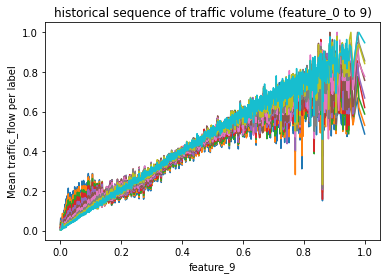

In [22]:
# historical sequence of traffic volume sensed during the 10 most recent sample points (10 features)

historical_seq_traffic_vol = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


for var in historical_seq_traffic_vol:
    print(var, '   Distinct Values: ', len(df_train_ds[var].unique()),'   Data Type: ', df_train_ds[var].dtypes)
      
    df_train_ds.groupby(var)['traffic_flow'].mean().plot()
    
plt.ylabel('Mean traffic_flow per label')
plt.title('historical sequence of traffic volume (feature_0 to 9)')    
plt.show()

From above plot, it's clear that strong correlation exists among these 10 historical sequence of traffic volume (feature_0 to 9). Approach to combine (mean) these 10 features to a single feature can be followed.

feature_10    Distinct Values:  2 [1. 0.]    Data Type:  float64
feature_11    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_12    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_13    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_14    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_15    Distinct Values:  2 [1. 0.]    Data Type:  float64
feature_16    Distinct Values:  2 [0. 1.]    Data Type:  float64


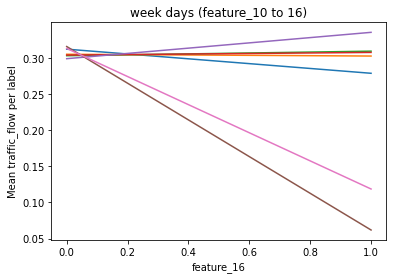

In [23]:
# week day (7 features)

week_days = ['feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16']

for var in week_days:
    print(var, '   Distinct Values: ', len(df_train_ds[var].unique()),df_train_ds[var].unique(),'   Data Type: ', df_train_ds[var].dtypes)
      
    df_train_ds.groupby(var)['traffic_flow'].mean().plot()
    
plt.ylabel('Mean traffic_flow per label')
plt.title('week days (feature_10 to 16)')    
plt.show()

From above plot, 5 of week day (7 features) tend to affect traffic flow in similar manner to some extent. May be these 5 days are weekdays when traffic pressure is high & remaining 2 days are weekends when traffic pressure is low due to holidays.

feature_17    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_18    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_19    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_20    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_21    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_22    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_23    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_24    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_25    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_26    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_27    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_28    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_29    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_30    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_31    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_32    Distinct Va

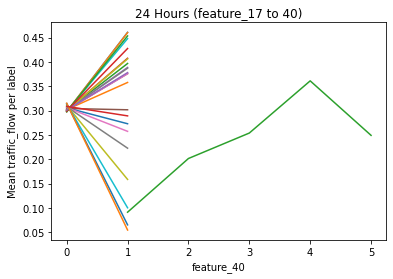

In [24]:
# hour of day (24 features)

hours_24 = ['feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23',
            'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30',
            'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37',
            'feature_38', 'feature_39', 'feature_40']

for var in hours_24:
    print(var, '   Distinct Values: ', len(df_train_ds[var].unique()),df_train_ds[var].unique(),'   Data Type: ', df_train_ds[var].dtypes)
      
    df_train_ds.groupby(var)['traffic_flow'].mean().plot()
    
plt.ylabel('Mean traffic_flow per label')
plt.title('24 Hours (feature_17 to 40)')    
plt.show()


In [25]:
len(df_train_ds[(df_train_ds['feature_39'] >= 2)])

44135

From above plot, no trend can be found for 24 Hours (feature_17 to 40). 

feature_39 (23 rd Hour) also contains value of 3, 4 & 5 as compared to 0,1 for other hours. Value of 3, 4 & 5 (values are absurd) might be outlier/noise for feature_39. We can drop feature_39 as it contains noise & does not signify hour feature. Instead, we will include feature_41 as hour feature.

feature_17    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_18    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_19    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_20    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_21    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_22    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_23    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_24    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_25    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_26    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_27    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_28    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_29    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_30    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_31    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_32    Distinct Va

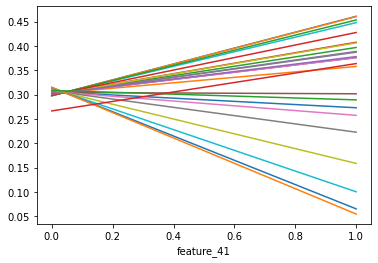

In [26]:
# new hour feature of day (24 features) -- feature_39 is dropped & replaced by feature_41

hours_24 = ['feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23',
            'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30',
            'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37',
            'feature_38', 'feature_40', 'feature_41']

for var in hours_24:
    print(var, '   Distinct Values: ', len(df_train_ds[var].unique()),df_train_ds[var].unique(),'   Data Type: ', df_train_ds[var].dtypes)
      
    df_train_ds.groupby(var)['traffic_flow'].mean().plot()

feature_42    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_43    Distinct Values:  2 [0. 1.]    Data Type:  float64
feature_44    Distinct Values:  2 [1. 0.]    Data Type:  float64
feature_45    Distinct Values:  2 [0. 1.]    Data Type:  float64


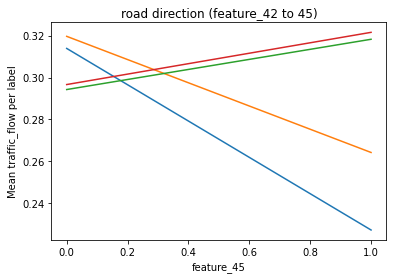

In [27]:
# road direction (4 features)
road_direction = ['feature_42', 'feature_43', 'feature_44', 'feature_45']

for var in road_direction:
    print(var, '   Distinct Values: ', len(df_train_ds[var].unique()), df_train_ds[var].unique(),'   Data Type: ', df_train_ds[var].dtypes)
      
    df_train_ds.groupby(var)['traffic_flow'].mean().plot()
    
plt.ylabel('Mean traffic_flow per label')
plt.title('road direction (feature_42 to 45)')    
plt.show()


From above plot, no trend/relation found among 4 road direction (feature_42 to 45). 

['feature_46']    Distinct Values:  2 [0. 1.]    Data Type:  float64


<AxesSubplot:xlabel='feature_46'>

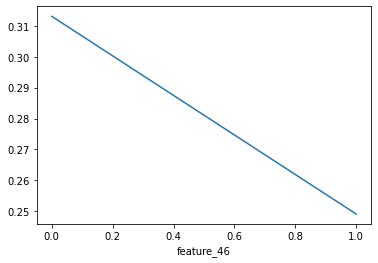

In [28]:
# number of lanes (1 feature)

no_of_lanes = ['feature_46']


print(no_of_lanes, '   Distinct Values: ', len(df_train_ds['feature_46'].unique()), df_train_ds['feature_46'].unique(),'   Data Type: ', df_train_ds['feature_46'].dtypes)
df_train_ds.groupby(no_of_lanes)['traffic_flow'].mean().plot()
    
# plt.ylabel('Mean traffic_flow per label')
# plt.title('number of lanes (feature_46)')    
# plt.show()

No specific observation for number of lanes (feature_46)

['feature_47']    Distinct Values:  2 [0. 1.]    Data Type:  float64


<AxesSubplot:xlabel='feature_46'>

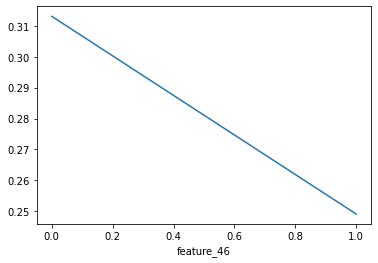

In [29]:
# name of the road (1 feature)

name_of_road = ['feature_47']


print(name_of_road, '   Distinct Values: ', len(df_train_ds['feature_47'].unique()), df_train_ds['feature_47'].unique(),'   Data Type: ', df_train_ds['feature_47'].dtypes)
df_train_ds.groupby(no_of_lanes)['traffic_flow'].mean().plot()
    
# plt.ylabel('Mean traffic_flow per label')
# plt.title('name of road (feature_47)')    
# plt.show()

No specific observation for name of the road (feature_47)

#### Types of problems within the variables

Missing Values & Duplicate Rows

In [30]:
# Count of column wise NA/Missing values

count = 0
df_train_ds.isnull().sum()
for var in df_train_ds.columns:
    if df_train_ds[var].isnull().sum() > 0:
        count = count + 1
        print(var, df_train_ds[var].isnull().mean())

print('No of Columns with missing values :',count)

No of Columns with missing values : 0


In [31]:
# Count number of duplicated Rows

duplicate_row_count = df_train_ds.duplicated().sum()
print('No of Duplicate Rows :',duplicate_row_count)

No of Duplicate Rows : 0


#### Outliers and distributions

#### Outliers & Distribution in continuous variables

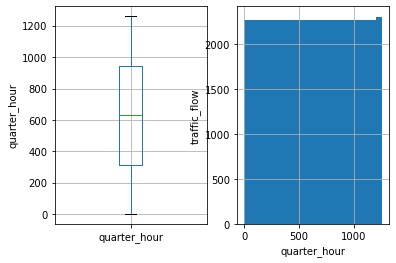

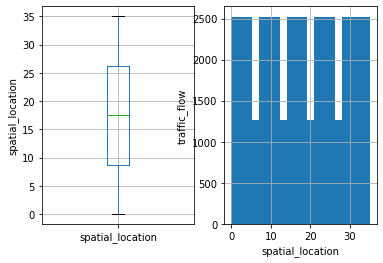

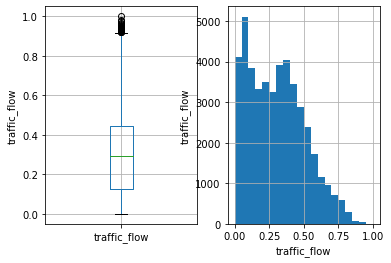

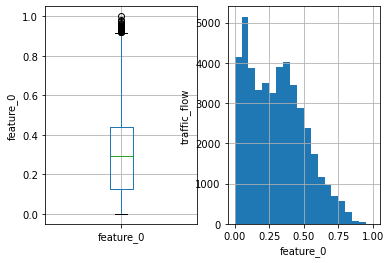

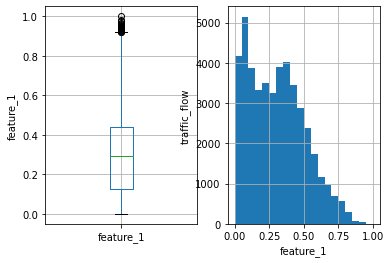

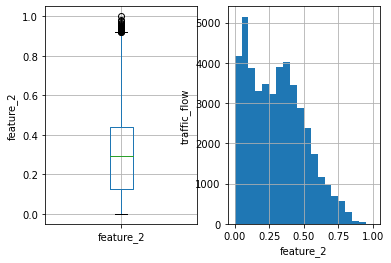

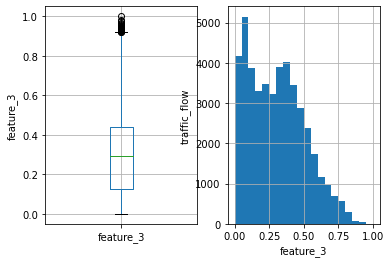

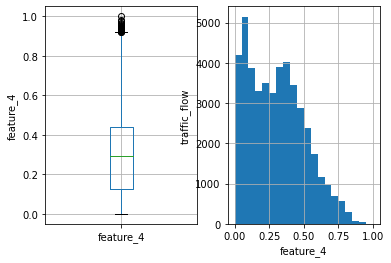

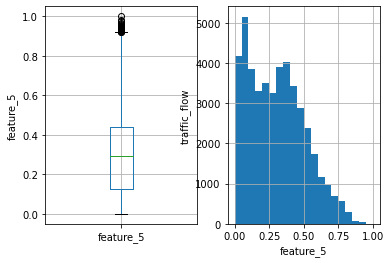

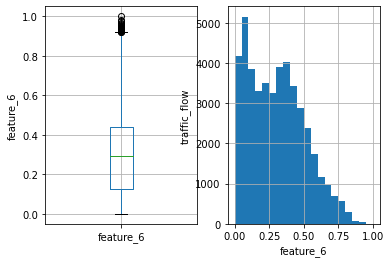

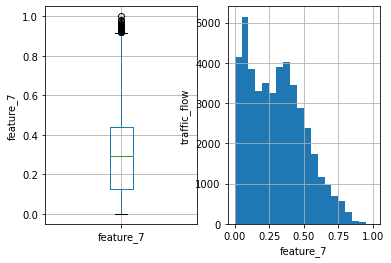

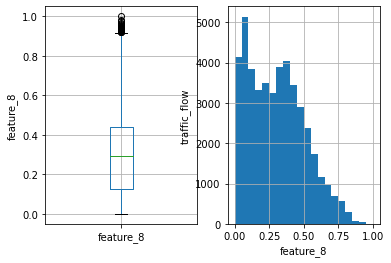

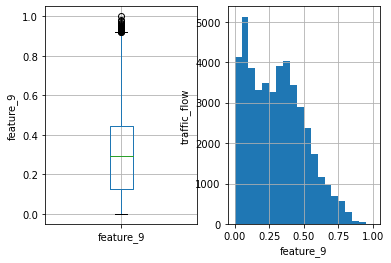

In [32]:
# let's make boxplots to visualise outliers in continuous variables & histograms to get an idea of its distribution

for var in continuous_var:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = df_train_ds.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df_train_ds[var].hist(bins=20)
    fig.set_ylabel('traffic_flow')
    fig.set_xlabel(var)

    plt.show()

The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. As we are planning to build linear regression, we need to tackle these to improve the model performance. 

#### Outliers in discrete variables

C:\Users\0394D9744\AppData\Local\Temp\ipykernel_8072\2129806175.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (df_train_ds.groupby(var)[var].count() / np.float(len(df_train_ds))).plot.bar()


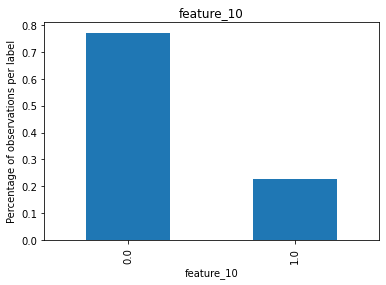

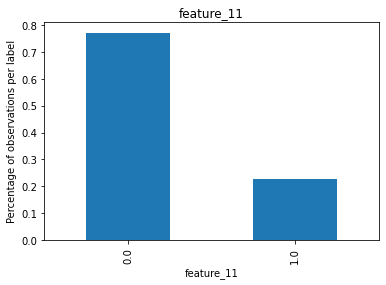

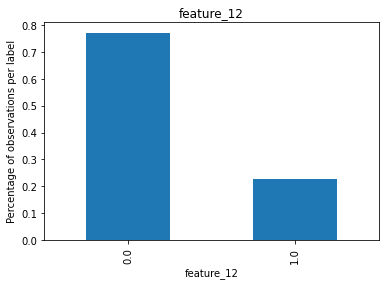

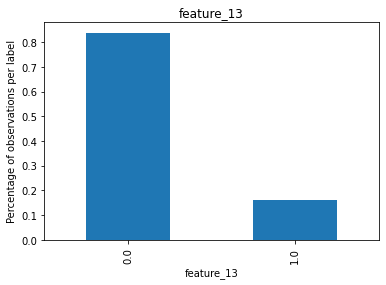

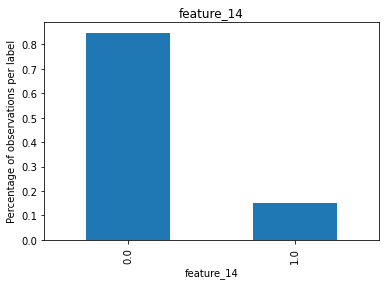

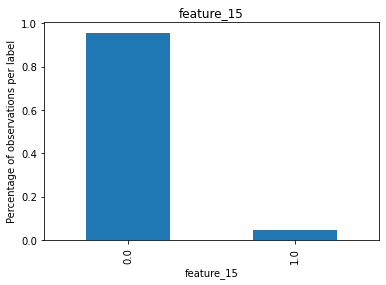

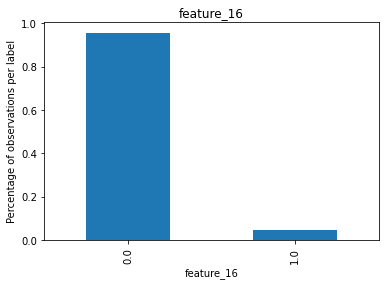

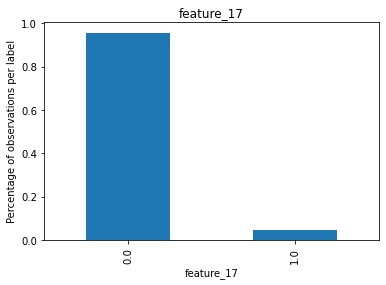

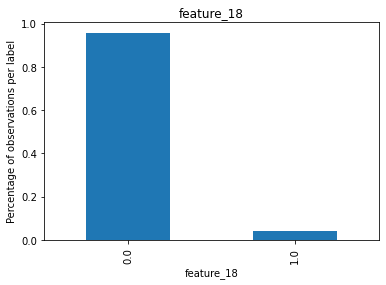

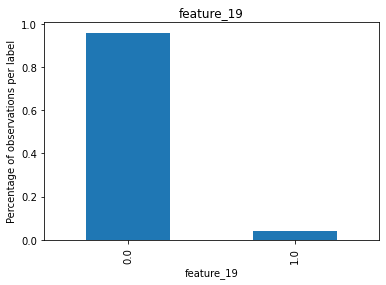

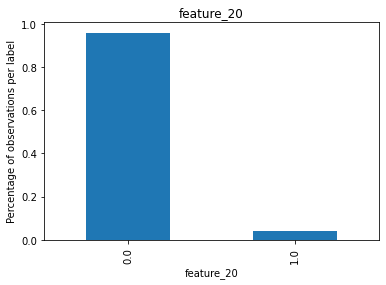

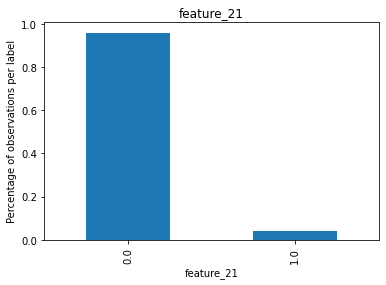

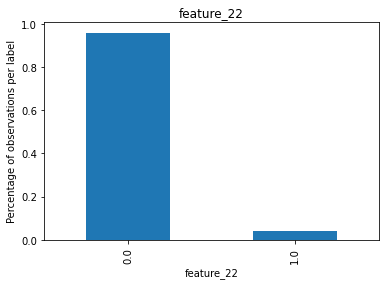

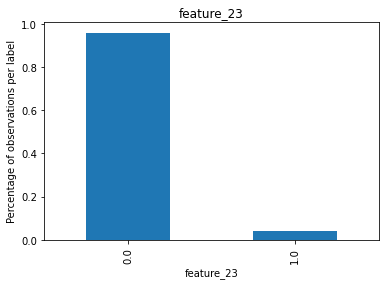

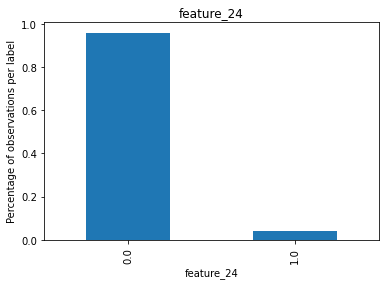

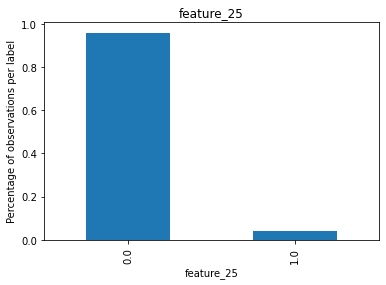

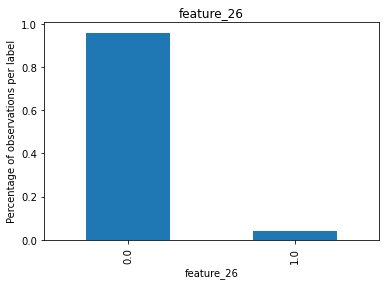

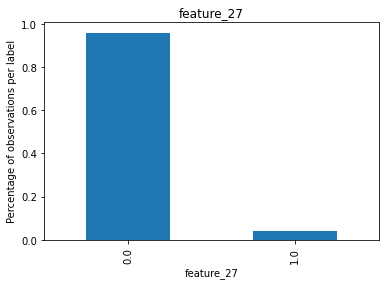

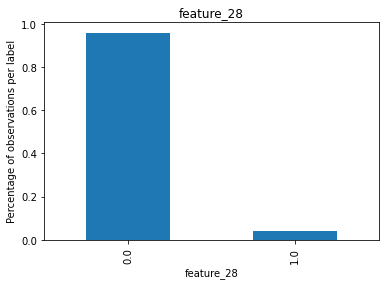

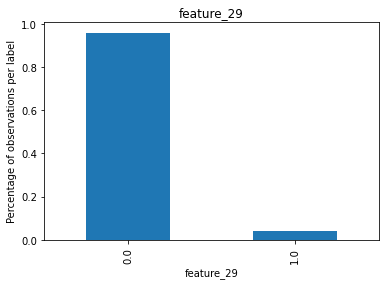

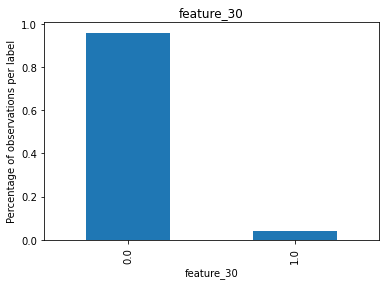

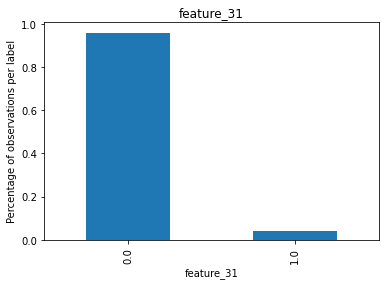

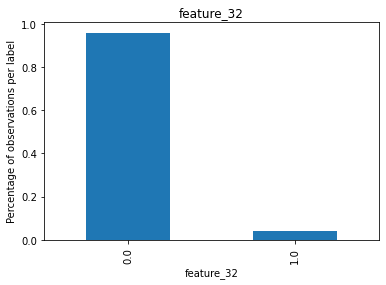

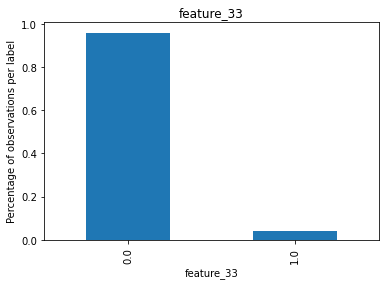

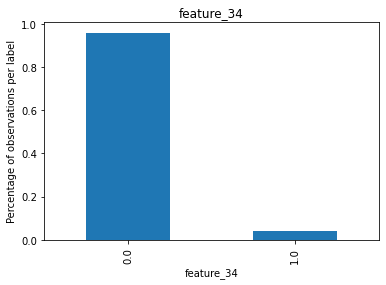

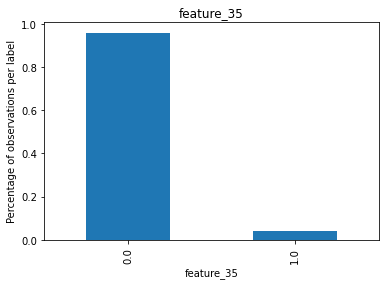

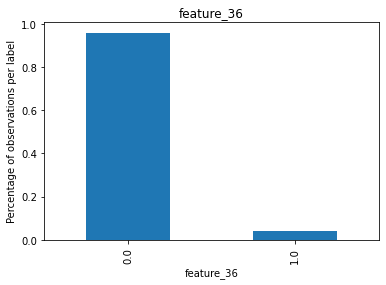

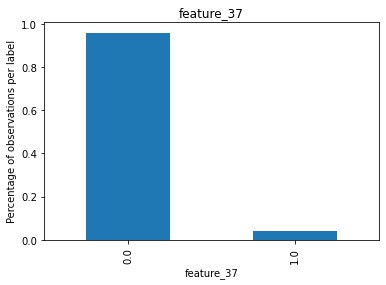

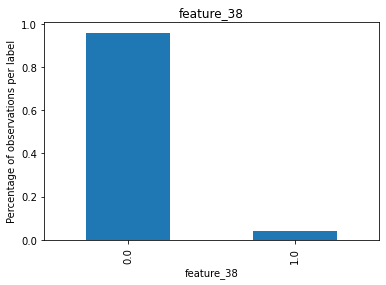

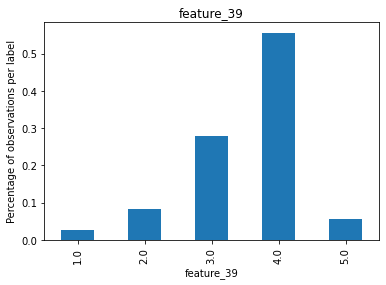

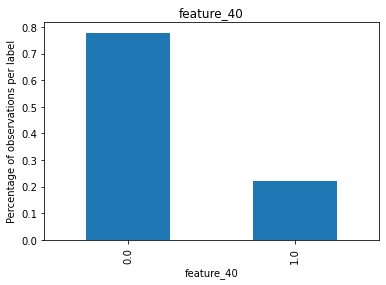

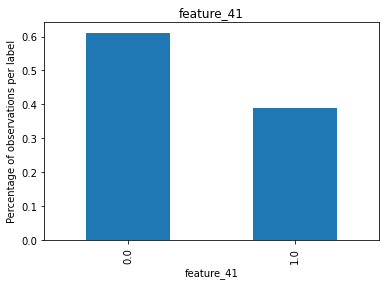

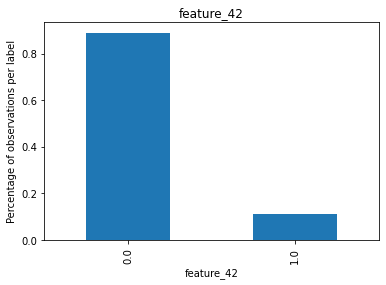

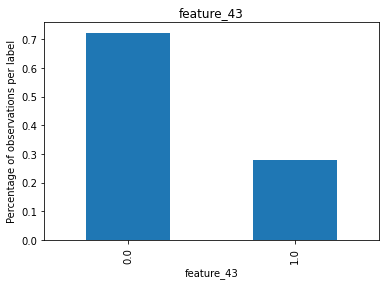

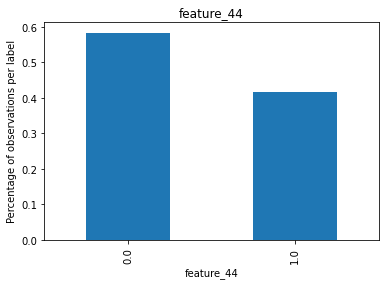

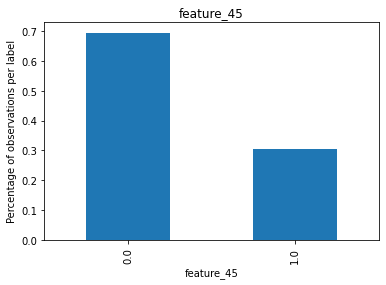

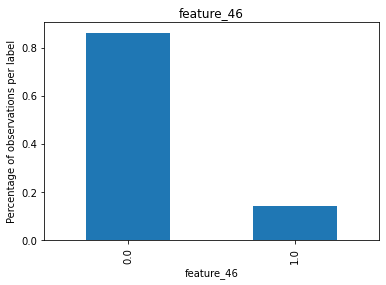

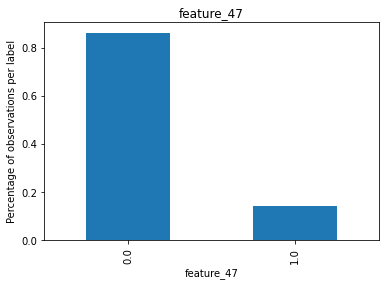

In [33]:
# outlies in discrete variables

for var in discrete_var:
    (df_train_ds.groupby(var)[var].count() / np.float(len(df_train_ds))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

Let's try to identify outliers in discrete variables. Will call outliers those values that are present in less than 5 % of total observations. Most of discrete variables show values that are shared by a tiny proportion of total observations in dataset.

#### Linear Model Assumptions

Some of linear regression model assumptions are:

- **Linearity**
- **No perfect multicollinearity**
- **Normally distributed errors**
- **Homoscedasticity**

##### 1. Linearity: 
Mean values of the outcome variable for each increment of predictor(s) lie along a straight line. There is a linear relationship between predictors and target. We evaluate linear assumption with plots. 

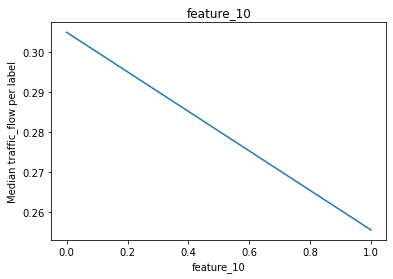

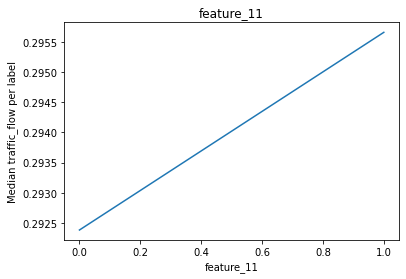

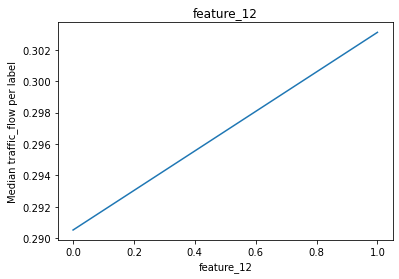

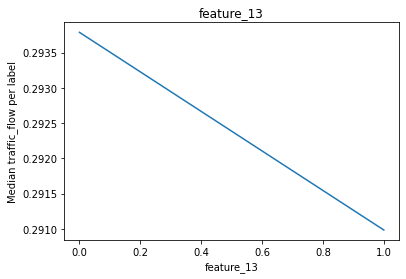

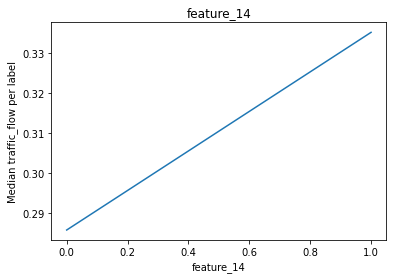

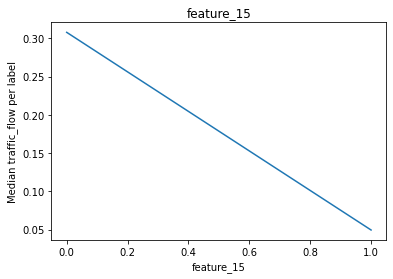

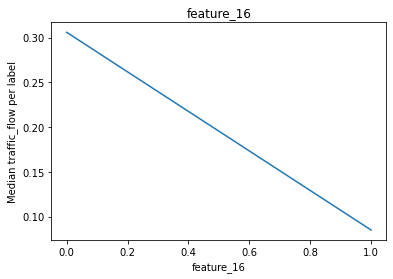

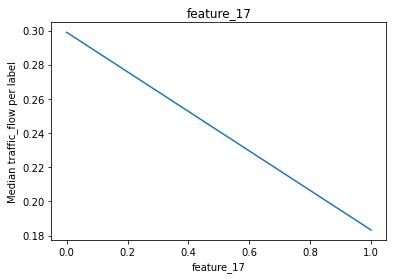

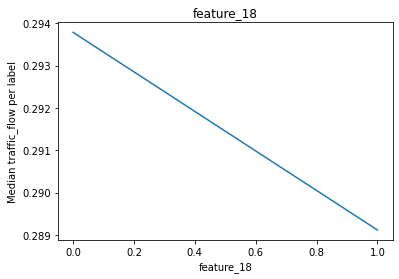

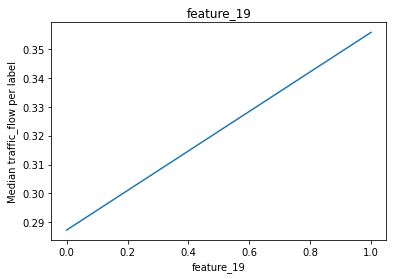

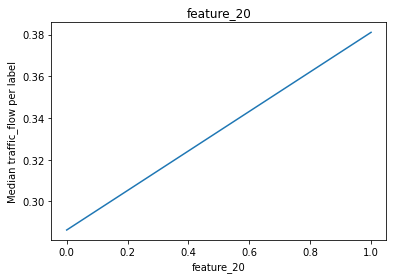

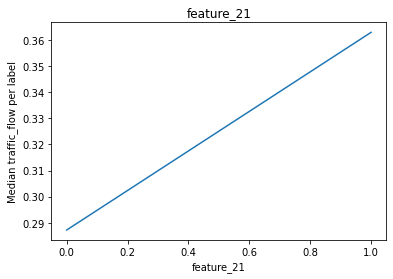

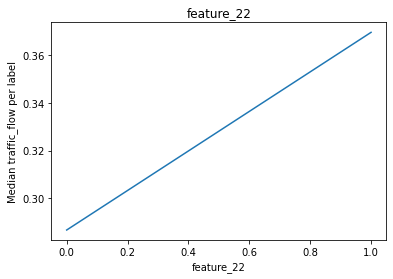

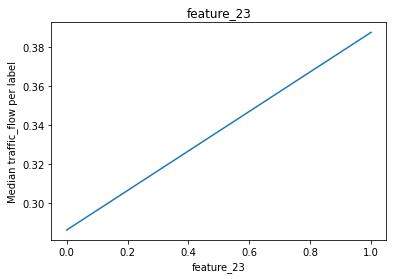

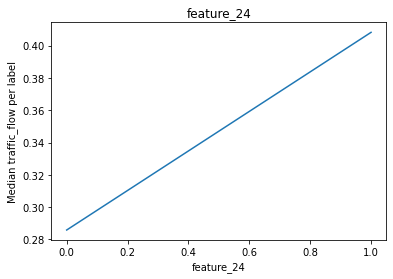

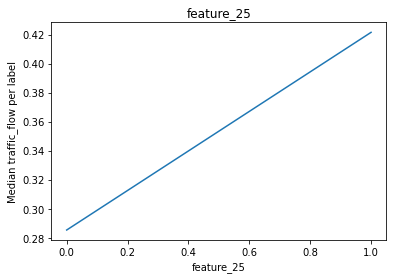

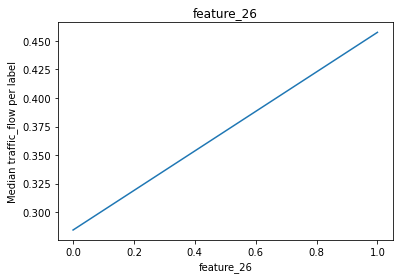

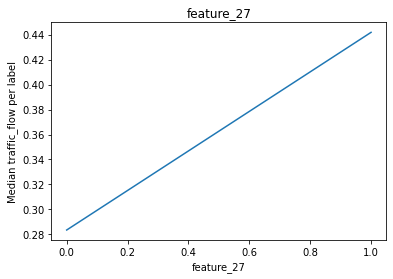

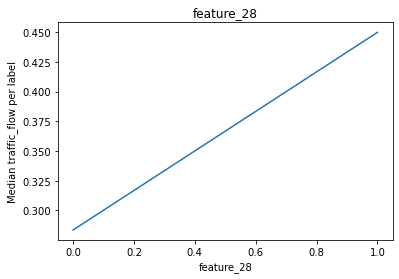

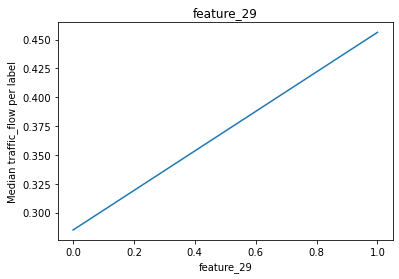

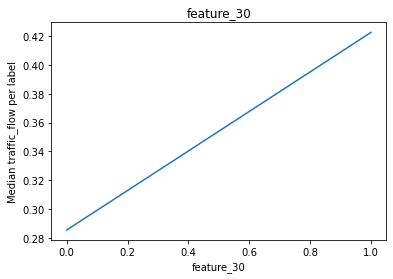

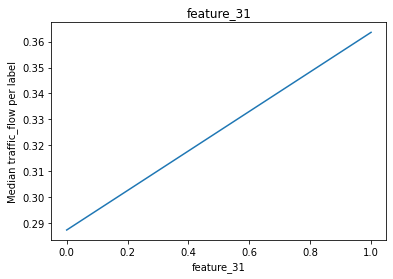

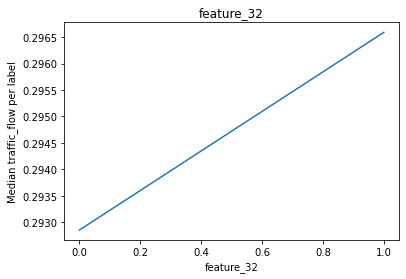

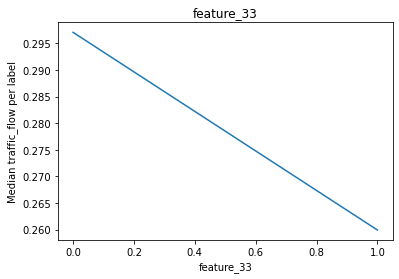

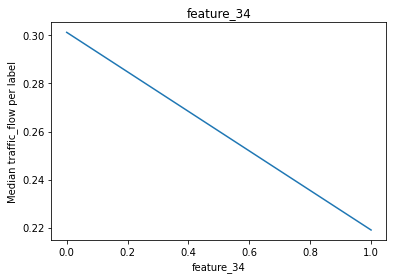

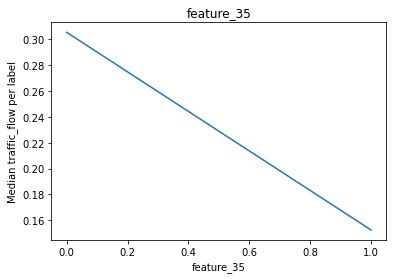

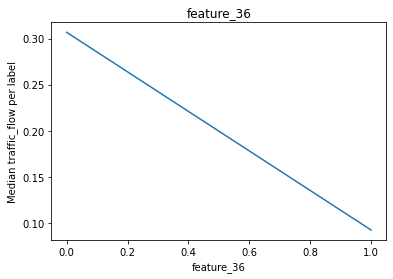

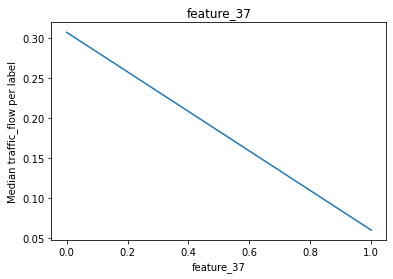

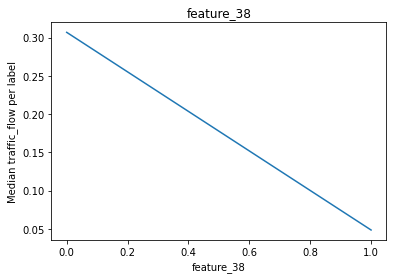

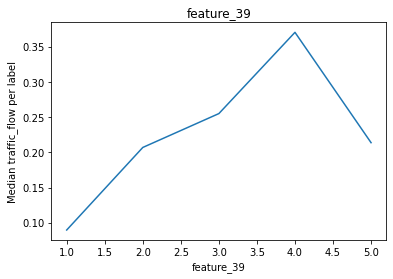

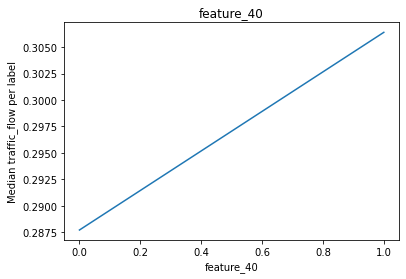

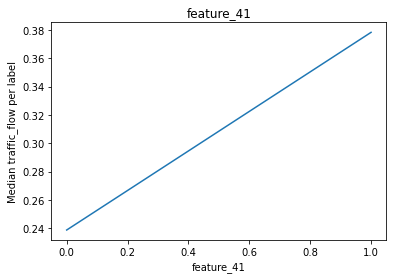

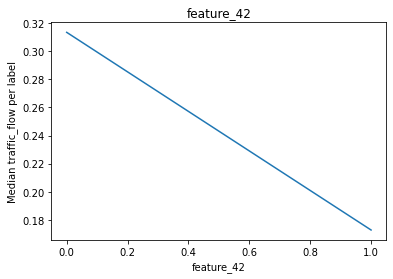

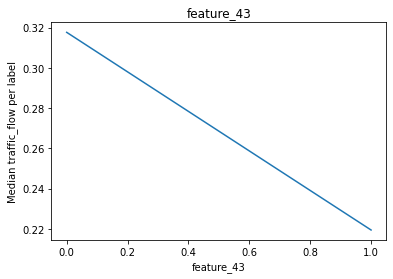

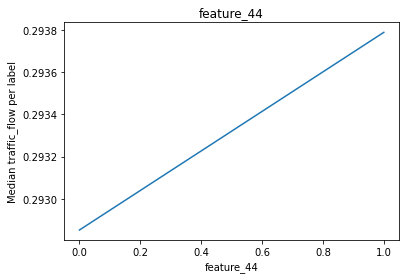

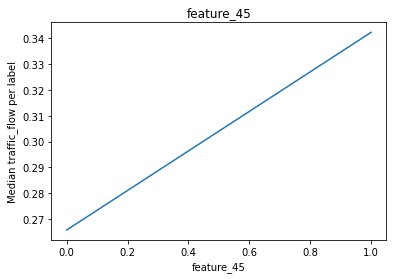

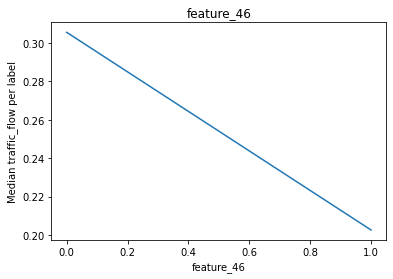

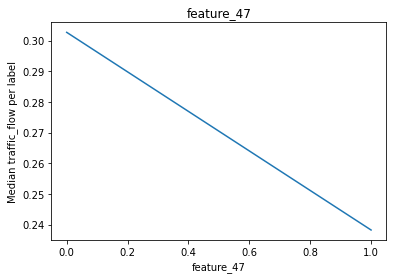

In [34]:
# let's scatter plot traffic_flow per value of discrete variable

for var in discrete_var:
    df_train_ds.groupby(var)['traffic_flow'].median().plot()
    plt.ylabel('Median traffic_flow per label')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


As per above Plots, not all discrete dependent variables are linearly dependent on target variables

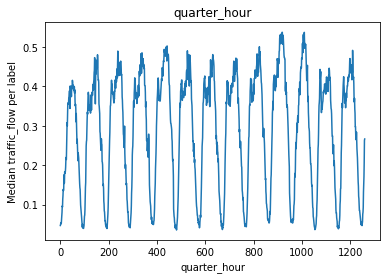

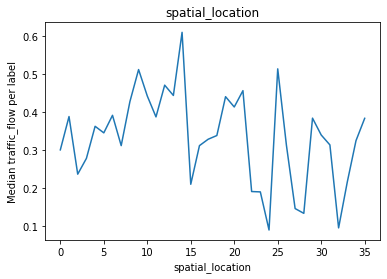

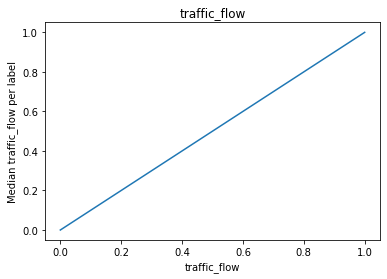

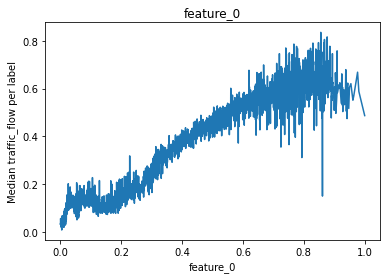

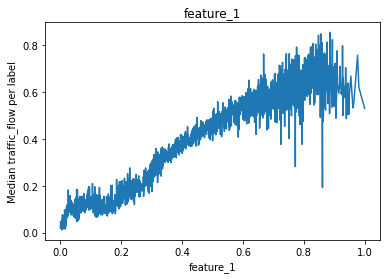

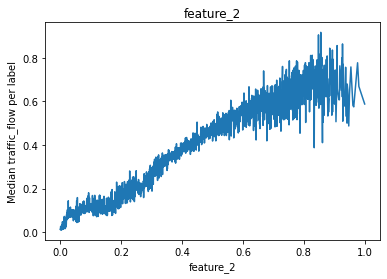

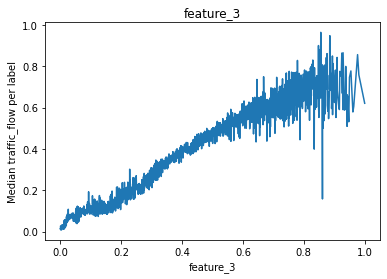

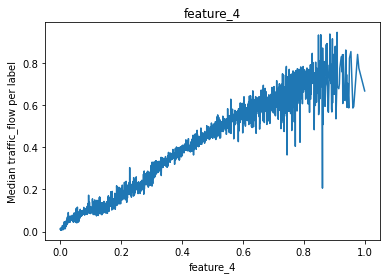

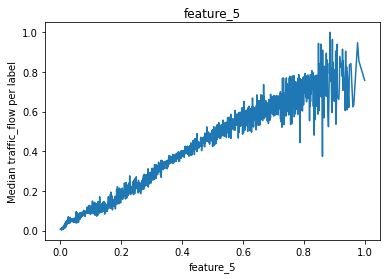

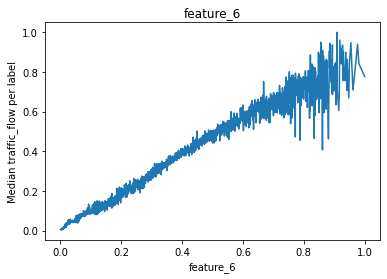

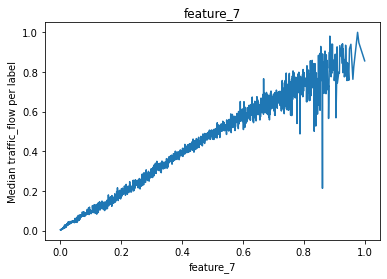

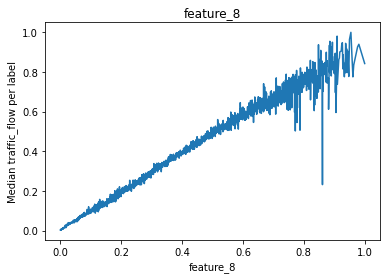

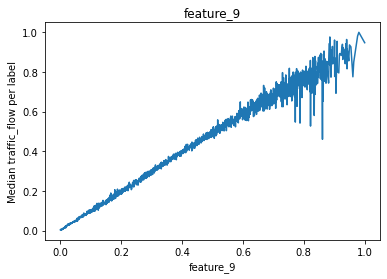

In [35]:
# let's plot the median sale price per value of continious variable

for var in continuous_var:
    df_train_ds.groupby(var)['traffic_flow'].median().plot()
    plt.ylabel('Median traffic_flow per label')
    plt.title(var)
    plt.show()

As per above Plots, all continuous dependent variables (except quarter_hour, spatial location) are linearly dependent on target variable. 

##### 2. No perfect multicollinearity: 
    
There should be no perfect linear relationship 
between two or more of the predictors.

Collinearity among Continuous Variables

<AxesSubplot:>

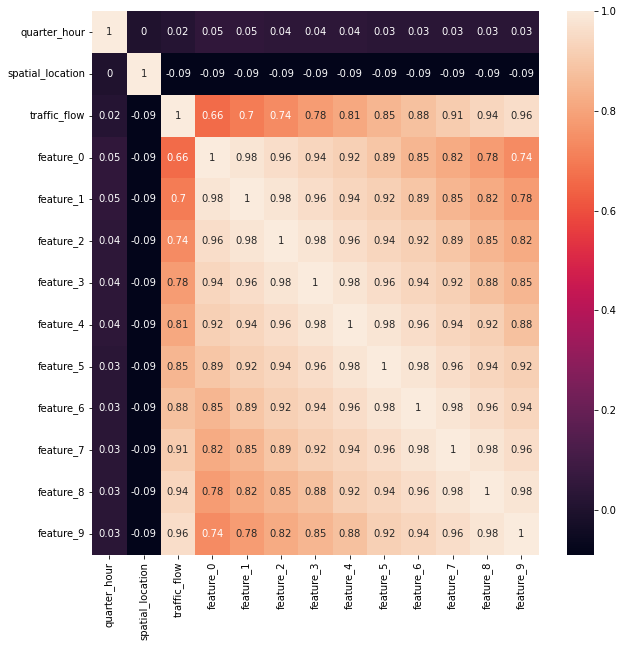

In [36]:
continuous_correlation_matrix = df_train_ds[continuous_var].corr().round(2)

# plot the correlation matrix usng seaborn
# annot = True to print the correlation values
# inside the squares

figure = plt.figure(figsize=(10, 10))
sns.heatmap(data=continuous_correlation_matrix, annot=True)

As feature_0 to feature_9 are highly correlated among all continuous variables, we can derive only one feature (taking mean of them) & then drop feature_0 till feature_9 in final dataset.

In [37]:
df_train_ds['his_traffic_mean'] = df_train_ds[['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']].mean(axis=1)

df_train_ds.drop(['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9'], axis=1,inplace=True)

for i in ('feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9'):
    continuous_var.remove(i)


continuous_var.append('his_traffic_mean')

In [38]:
# dropped feature_39 as identified as in-significant feature
df_train_ds.drop(['feature_39'], axis=1,inplace=True) 
discrete_var.remove('feature_39')

In [39]:
df_train_ds.head()

,quarter_hour,spatial_location,traffic_flow,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,his_traffic_mean
0,0,0,0.050911,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.067912
1,0,1,0.046240,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.073984
2,0,2,0.050444,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.081644
3,0,3,0.044839,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.076039
4,0,4,0.044839,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.096310


Collinearity among Discrete Variables

<AxesSubplot:>

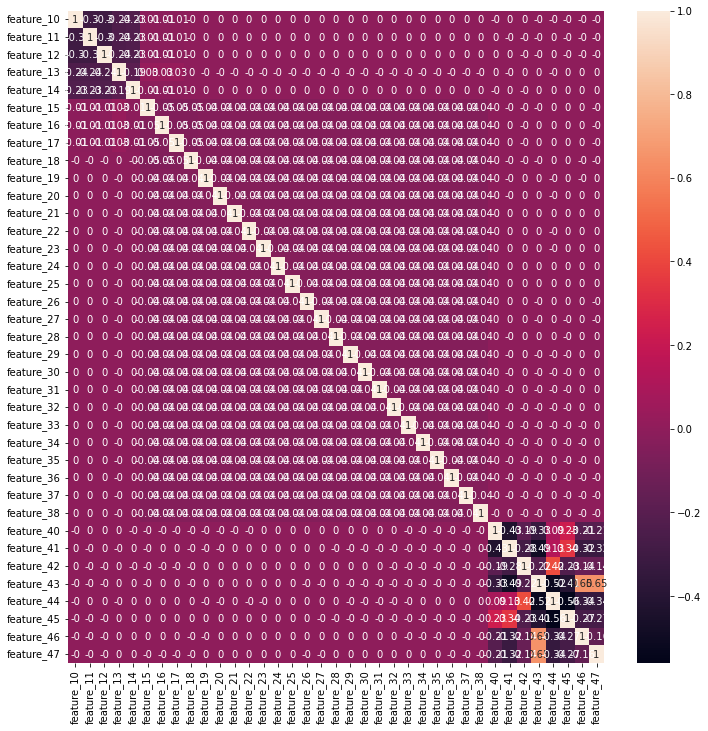

In [40]:
discrete_correlation_matrix = df_train_ds[discrete_var].corr().round(2)

figure = plt.figure(figsize=(12, 12))
sns.heatmap(data=discrete_correlation_matrix, annot=True)

As no features are highly correlated among all discrete variables, we can keep all of them in final dataset

#### Construction of Test Data Set

In [41]:
w = []
x = []
y = []
z = []


for i in (range(len(list_tra_Y_te[0]))):   # i = 840 continious quarter-hours (0 to 839)
    for j in (range(len(list_tra_Y_te))):  # j = 36 spatial locations (0 to 35)
        w.append(i)
        x.append(j)
        y.append(list_tra_X_te[i][j])
        z.append(list_tra_Y_te[j][i])
        

test_ds = list(zip(w,x,y,z))

df_test_ds = pd.DataFrame(test_ds,columns=column_df)

df_test_ds[[f'feature_{i}' for i in range(0,48)]]=pd.DataFrame(df_test_ds["input_matrix"].tolist(), index = df_test_ds.index)        
df_test_ds = df_test_ds.drop('input_matrix', axis=1)

In [42]:
df_test_ds_original = df_test_ds
# len(df_test_ds)

Training & Testing DataSet

In [43]:
y_train = df_train_ds['traffic_flow']
x_train = df_train_ds.drop(['traffic_flow'], axis=1)

In [44]:
df_test_ds['his_traffic_mean'] = df_test_ds[['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']].mean(axis=1)

df_test_ds.drop(['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9'], axis=1,inplace=True)
df_test_ds.drop(['feature_39'], axis=1,inplace=True)

y_test = df_test_ds['traffic_flow']
x_test = df_test_ds.drop(['traffic_flow'], axis=1)

#### Feature Scaling

In [45]:
# let's scale the features using Standardisation for linear models

scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [46]:
# Dataframe to store Performance of different matrices
model_perf = pd.DataFrame()

### Different Regression Models

### Linear Regression Model

##### Model Training & Prediction

In [47]:
model_linear_reg = LinearRegression() 
model_linear_reg.fit(scaler.transform(x_train),y_train)
predict_linear_reg = model_linear_reg.predict(scaler.transform(x_test))

#### Model Performance:

In [48]:
mse = mean_squared_error(y_test, predict_linear_reg)
rmse = sqrt(mse)
r2_scr = r2_score(y_test, predict_linear_reg)

print('Model Performance of Linear Regression Model :')
print('test mse: {}'.format(mse))
print('test rmse: {}'.format(rmse))
print('test r2: {}'.format(r2_scr))

Model Performance of Linear Regression Model :
test mse: 0.005075941090217136
test rmse: 0.07124563909613792
test r2: 0.8785968288210853


In [49]:
# Calculation of Mean Absolute Percentage Error(MAPE)

# function to return the MAPE values

def calculate_mape(actual, predicted):
    APE = []
    # Iterate over the list values
    for val in range(len(predicted)):
        # Calculate percentage error
        per_err = (actual[val] - predicted[val]) / actual[val]
        # Take absolute value of
        # the percentage error (APE)
        per_err = abs(per_err)
        
        # Append it to the APE list
        APE.append(per_err)
        # Calculate the MAPE
        MAPE = round(sum(APE)/len(APE)*100)
        return MAPE

In [50]:
# Get MAPE for python list as parameters
mape_linear_reg = calculate_mape(y_test,predict_linear_reg)

print('Mean Absolute Percentage Error(MAPE) of Linear Regression Model in Test Data Set is :',mape_linear_reg, "%")

Mean Absolute Percentage Error(MAPE) of Linear Regression Model in Test Data Set is : 8 %


In [51]:
mape = mape_linear_reg
row_perf = pd.Series(['linear_reg',mse,rmse,r2_scr,mape])
model_perf = model_perf.append([list(row_perf)])

#### 3.  Normally Distributed Errors: 
Residuals are random, normally distributed with a mean of 0.

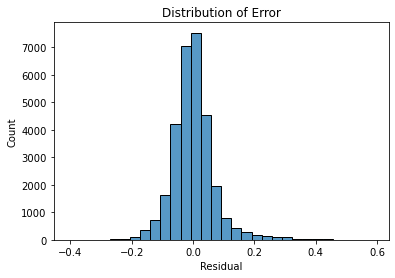

In [52]:
# calculate the residuals
error_linear_reg = y_test - predict_linear_reg

# Residual normality
# we will make a histogram to determine if residuals are normally distributed with mean value at 0

sns.histplot(error_linear_reg, bins=30)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Distribution of Error')
plt.show()

We see that the residuals show a fairly normal distribution centred at 0. Not perfect, by visual inspection there is some skew towards both ends with a few higher unusual values.

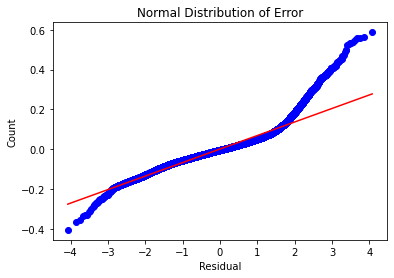

In [53]:
# we can better visualize residuasl distribution with a Q-Q plot. 
# If residuals are normally distributed, dots should adjust to the 45 degree line

stats.probplot(error_linear_reg, dist="norm", plot=plt)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Normal Distribution of Error')
plt.show()

From the Q-Q plot we see more easily how the residuals deviate from the red line towards the ends of the distribution, thus, they are not completely normally distributed.

Text(0, 0.5, 'Predicted Traffic Flow')

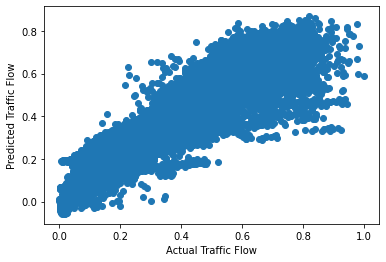

In [54]:
# plot predictions vs real value

plt.scatter(y_test,predict_linear_reg)
plt.xlabel('Actual Traffic Flow')
plt.ylabel('Predicted Traffic Flow')

#### 4.  Homoscedasticity
Homoscedasticity implies that at each level of the predictor variable(s), the variance of the residual terms should be constant. So we need to plot the residuals against the variables.

Homoscedasticity, also known as homogeneity of variance, describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables X and the dependent variable Y is the same across all the independent variables.

Text(0, 0.5, 'Residuals')

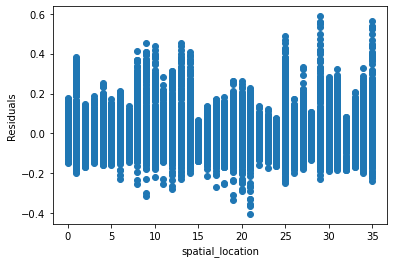

In [55]:
# plot the residuals vs one of the independentvariables (spatial_location)

plt.scatter(x=x_test['spatial_location'], y=error_linear_reg)
plt.xlabel('spatial_location')
plt.ylabel('Residuals')

The residuals seem fairly homogeneously distributed across the values of spatial_location.

Text(0, 0.5, 'Residuals')

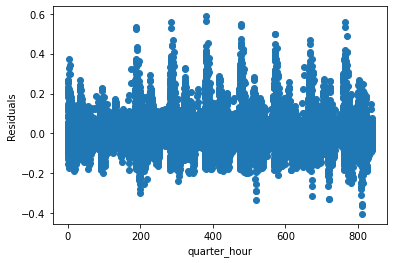

In [56]:
# plot the residuals vs one of the independent variables (quarter_hour)

plt.scatter(x=x_test['quarter_hour'], y=error_linear_reg)
plt.xlabel('quarter_hour')
plt.ylabel('Residuals')

The residuals seem fairly homogeneously distributed across the values of quarter_hour.

### Ridge Regression algorithm

##### Model Training & Prediction

In [57]:
model_ridge = Ridge(alpha =1.0)
model_ridge.fit(scaler.transform(x_train),y_train)
predict_ridge = model_ridge.predict(scaler.transform(x_test))

#### Model Performance:

In [58]:
mse = mean_squared_error(y_test, predict_ridge)
rmse = sqrt(mse)
r2_scr = r2_score(y_test, predict_ridge)

print('Model Performance of Ridge Regression Model :')
print('test mse: {}'.format(mse))
print('test rmse: {}'.format(rmse))
print('test r2: {}'.format(r2_scr))

Model Performance of Ridge Regression Model :
test mse: 0.00507665932770123
test rmse: 0.07125067948940017
test r2: 0.8785796504680117


In [59]:
# Get MAPE for python list as parameters
mape_ridg = calculate_mape(y_test,predict_ridge)

print('Mean Absolute Percentage Error(MAPE) of Lidge Regression Model in Test Data Set is :',mape_ridg, "%")

Mean Absolute Percentage Error(MAPE) of Lidge Regression Model in Test Data Set is : 8 %


In [60]:
mape = mape_ridg

row_perf = pd.Series(['ridge_reg',mse,rmse,r2_scr,mape])
model_perf = model_perf.append([list(row_perf)])

### Lasso Regression Model

##### Model Training & Prediction

In [61]:
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(scaler.transform(x_train),y_train)
predict_lasso = model_lasso.predict(scaler.transform(x_test))

#### Model Performance

In [62]:
mse = mean_squared_error(y_test, predict_lasso)
rmse = sqrt(mse)
r2_scr = r2_score(y_test, predict_lasso)

print('Model Performance of Lasso Regression Model :')
print('test mse: {}'.format(mse))
print('test rmse: {}'.format(rmse))
print('test r2: {}'.format(r2_scr))

Model Performance of Lasso Regression Model :
test mse: 0.021773409539661115
test rmse: 0.14755815646605616
test r2: 0.4792372648716027


In [63]:
# Get MAPE for python list as parameters
mape_lasso = calculate_mape(y_test,predict_lasso)

print('Mean Absolute Percentage Error(MAPE) of Lasso Regression Model in Test Data Set is :',mape_lasso, "%")

Mean Absolute Percentage Error(MAPE) of Lasso Regression Model in Test Data Set is : 34 %


In [64]:
mape = mape_lasso

row_perf = pd.Series(['lasso_reg',mse,rmse,r2_scr,mape])
model_perf = model_perf.append([list(row_perf)])

### Random Forest Algorithm

##### Model Training & Prediction

In [65]:
model_randomforest = RandomForestRegressor(n_estimators=100)
model_randomforest.fit(scaler.transform(x_train),y_train)
predict_randomforest = model_randomforest.predict(scaler.transform(x_test))

#### Model Performance

In [66]:
mse = mean_squared_error(y_test, predict_randomforest)
rmse = sqrt(mse)
r2_scr = r2_score(y_test, predict_lasso)

print('Model Performance of Random Forest Model :')
print('test mse: {}'.format(mse))
print('test rmse: {}'.format(rmse))
print('test r2: {}'.format(r2_scr))

Model Performance of Random Forest Model :
test mse: 0.002046509727110714
test rmse: 0.045238365654726234
test r2: 0.4792372648716027


In [67]:
# Get MAPE for python list as parameters

mape_randomforest = calculate_mape(y_test,predict_randomforest)

# mape_randomforest_1 = mean_absolute_percentage_error(y_test, predict_randomforest)

print('Mean Absolute Percentage Error(MAPE) of Random Forest Model in Test Data Set is :',mape_randomforest, "%")

Mean Absolute Percentage Error(MAPE) of Random Forest Model in Test Data Set is : 3 %


In [68]:
mape = mape_randomforest

row_perf = pd.Series(['random_forest',mse,rmse,r2_scr,mape])
model_perf = model_perf.append([list(row_perf)])

#### Hyper-parameter Tuning of Different Models

Declaration of Different Models along with their hyper-parameter ranges

In [69]:
model_param = {
    'ridge': {
        'model': Ridge(),
        'params' : {
            'alpha': [0.1, 1.0]
        }  
    },
    'lasso': {
        'model': Lasso(),
        'params' : {
            'alpha': [0.1, 1.0]
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [1,5,10,50,100]
        }
    }     
}

Set-up & Fitting on GridSearchCV

In [70]:
from sklearn.model_selection import GridSearchCV

scores_gs = []

for model_name, mp in model_param.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(scaler.transform(x_train),y_train)
    scores_gs.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

Summary of Models along with best Score & Hyper-parameters

In [71]:
df_gs = pd.DataFrame(scores_gs,columns=['model','best_score','best_params'])
print('Model wise Best Score along with Best Hyper-parameter values \n')
df_gs

Model wise Best Score along with Best Hyper-parameter values 



,model,best_score,best_params
0,ridge,0.868191,{'alpha': 1.0}
1,lasso,0.480031,{'alpha': 0.1}
2,random_forest,0.931188,{'n_estimators': 100}


#### Final File containing Predicted Traffic Volume

In [72]:
y_test.to_csv(r'tra_Y_te_predicted.csv',index = False)
print('Predicted Traffic Volume of Test Data(tra_X_te) is stored in file tra_Y_te_predicted.csv')

Predicted Traffic Volume of Test Data(tra_X_te) is stored in file tra_Y_te_predicted.csv


#### Comparative Performance Matrix of Models

In [73]:
# Setting up of Index Column
index = []
for i in range(len(model_perf)):
    index.append(i)
    
model_perf['index'] = index  
model_perf.set_index('index', inplace=True)

In [74]:
model_perf.rename({0:'model_name' , 1:'mse', 2:'rmse',  3:'r2_score', 4:'mape'}, axis=1, inplace=True)

print('Comparative Performance Matrix of Models based on Test Data \n')
print(model_perf)

print('\n\n')
print('Best Model of this test set is {} having highest r^2_score as {}  ' .format(model_perf.iloc[model_perf['r2_score'].idxmax,0], model_perf['r2_score'].max()))

print('\n')
print('Best Model of this test set is {} having lowest RSME as {}  ' .format(model_perf.iloc[model_perf['rmse'].idxmin,0], model_perf['rmse'].min()))

Comparative Performance Matrix of Models based on Test Data 

          model_name       mse      rmse  r2_score  mape
index                                                   
0         linear_reg  0.005076  0.071246  0.878597     8
1          ridge_reg  0.005077  0.071251  0.878580     8
2          lasso_reg  0.021773  0.147558  0.479237    34
3      random_forest  0.002047  0.045238  0.479237     3



Best Model of this test set is linear_reg having highest r^2_score as 0.8785968288210853  


Best Model of this test set is random_forest having lowest RSME as 0.045238365654726234  
